In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)
data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

data_all.shape

In [35]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features
import pandas as pd
import pickle
import os
import numpy as np
from copy import deepcopy


def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>50:
        return [],[],[],[],[],[],[]
    index2 = np.isnan(ecg_rr)
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    weights = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         ppg_qual[index2] = -.1
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -.5
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[tmp[:,k]>0,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        weights.append(np.abs(tmp[:,0]-ecg_rr).reshape(1,60,1))
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals,weights

# unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    if len(np.where(df[:,-6]>=.6)[0])<5:
        return np.zeros((0,60,11))
    return df.reshape(-1,60,11)

def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return [],[],[],[],[],[],[]
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col


def get_df(f):
    data_all = pickle.load(open(f,'rb'))
    data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
    data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
    data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
    data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
    data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
    data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
    data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
    values = data_all[['ppg_rr','index']].values
    values = [a[b] for a,b in values]
    data_all['ppg_rr_best'] = values
    data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))
    return get_all_data(data_all)

directory = '../data_users/ecg_ppg/'
all_X = Parallel(n_jobs=30,verbose=5)(delayed(get_df)(directory+f) for f in os.listdir(directory) if f[-1]=='p')
# all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  13 tasks      | elapsed:   17.9s
[Parallel(n_jobs=30)]: Done  98 out of 130 | elapsed:  1.9min remaining:   37.9s
[Parallel(n_jobs=30)]: Done 125 out of 130 | elapsed:  2.5min remaining:    5.9s
[Parallel(n_jobs=30)]: Done 130 out of 130 | elapsed:  2.6min finished


In [36]:
X,y,ecg,means,stds,quals,weights = [],[],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])
        weights.extend(a[6])

In [37]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals,weights],open('../data_users/processed_data_weights.p','wb'),protocol=4)

In [38]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals,weights = pickle.load(open('../data_users/processed_data_weights.p','rb'))

In [39]:
X,y,ecg,means,stds,quals,weights = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals).reshape(-1,60),np.concatenate(weights).reshape(-1,60)

In [40]:
quals.shape

(160042, 60)

In [41]:
# weights[weights>400] = 400
# weights = 1- weights/400
# weights[weights<.2] = .2
# quals[quals<.2] = .2
# quals = quals+1

In [42]:
np.unique(quals.reshape(-1))

array([-1.        ,  0.        ,  0.00166667, ...,  0.998     ,
        0.99857143,  1.        ])

In [43]:
# weights.shape,y.shape
from copy import deepcopy
r = deepcopy(quals)
r[r<.1] = .1
# r = r+.5
y = np.concatenate([y.reshape(-1,60,1),r.reshape(-1,60,1)],axis=2)

In [44]:
y.shape

(160042, 60, 2)

In [45]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test1,ecg_train, \
ecg_test,weights_train,weights_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,4,5,6])], y,ecg,weights,quals, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val,weights_train,weights_val = train_test_split(
    X_train, y_train,weights_train, test_size=0.2, random_state=4)
print(X_train.shape,y_train.shape,y_test1.shape,y_val.shape,weights_val.shape)

(102426, 60, 6) (102426, 60, 2) (32009, 60, 2) (25607, 60, 2) (25607, 60)


In [46]:
def meanabserror(y_true,y_pred):
    diff = K.abs((y_true - y_pred))
    return K.mean(diff, axis=-1)

def custom_mae(y_true,y_pred):
    weights = y_true[:,:,1]
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.abs((y_true - y_pred)
                 / K.clip(K.abs(y_true),K.epsilon(),None))
    diff = diff*weights
    return .4*K.mean(diff, axis=-1) +  .6*losses.mean_absolute_error(y_true,y_pred)
#     return losses.mean_absolute_error(y_true,y_pred)

timesteps = 60
input_dim = 6
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = Flatten()(mer)
encoded = Dense(30,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
encoded = RepeatVector(2)(encoded)
encoded = Permute((2,1))(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
sequence_autoencoder.compile(optimizer='adam',loss=custom_mae)
sequence_autoencoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 60, 6)        0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 60, 120)      24120       input_7[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 60, 1)        121         bidirectional_7[0][0]            
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 60)           0           dense_7[0][0]                    
____________________________________________________________________________________________

In [ ]:
filepath = '../models/base_LSTM_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 102426 samples, validate on 25607 samples
Epoch 1/300
102426/102426 [==============================] - 44s 432us/step - loss: 152.4559 - val_loss: 95.9041

Epoch 00001: val_loss improved from inf to 95.90408, saving model to ../models/base_LSTM_weights.hdf5
Epoch 2/300
102426/102426 [==============================] - 43s 423us/step - loss: 94.9869 - val_loss: 93.8493

Epoch 00002: val_loss improved from 95.90408 to 93.84925, saving model to ../models/base_LSTM_weights.hdf5
Epoch 3/300
102426/102426 [==============================] - 43s 423us/step - loss: 93.8258 - val_loss: 91.4290

Epoch 00003: val_loss improved from 93.84925 to 91.42900, saving model to ../models/base_LSTM_weights.hdf5
Epoch 4/300
102426/102426 [==============================] - 43s 421us/step - loss: 89.8160 - val_loss: 88.4063

Epoch 00004: val_loss improved from 91.42900 to 88.40631, saving model to ../models/base_LSTM_weights.hdf5
Epoch 5/300
102426/102426 [==============================] - 43s 422us/st

102426/102426 [==============================] - 43s 420us/step - loss: 73.3693 - val_loss: 73.0436

Epoch 00043: val_loss improved from 73.21952 to 73.04360, saving model to ../models/base_LSTM_weights.hdf5
Epoch 44/300
102426/102426 [==============================] - 43s 421us/step - loss: 73.2840 - val_loss: 72.9226

Epoch 00044: val_loss improved from 73.04360 to 72.92256, saving model to ../models/base_LSTM_weights.hdf5
Epoch 45/300
102426/102426 [==============================] - 43s 421us/step - loss: 73.2803 - val_loss: 74.1845

Epoch 00045: val_loss did not improve from 72.92256
Epoch 46/300
102426/102426 [==============================] - 43s 422us/step - loss: 73.3434 - val_loss: 72.4689

Epoch 00046: val_loss improved from 72.92256 to 72.46886, saving model to ../models/base_LSTM_weights.hdf5
Epoch 47/300
102426/102426 [==============================] - 43s 422us/step - loss: 73.1636 - val_loss: 73.4783

Epoch 00047: val_loss did not improve from 72.46886
Epoch 48/300
10242

In [ ]:
# from keras.models import load_model
# import tensorflow_probability as tfp
# sequence_autoencoder = load_model(filepath)
model_json = sequence_autoencoder.to_json()
with open('../models/model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
sequence_autoencoder.save_weights(filepath)

In [ ]:
sequence_autoencoder.load_weights('../models/base_LSTM_weights.hdf5')

In [15]:
y_train.shape,y_test1.shape

((98816, 60, 2), (30880, 60, 2))

In [16]:
y_pred1 = sequence_autoencoder.predict(X_test)

In [17]:
y_pred1.shape,y_test1.shape

((30880, 60, 2), (30880, 60, 2))

In [18]:
y_pred = y_pred1[:,:,0].reshape(-1,60)
y_test = y_test1[:,:,0].reshape(-1,60)

In [19]:
y_pred[0].shape,y_pred[1].shape,y_pred[2].shape,quals_test[0].shape

((60,), (60,), (60,), (60,))

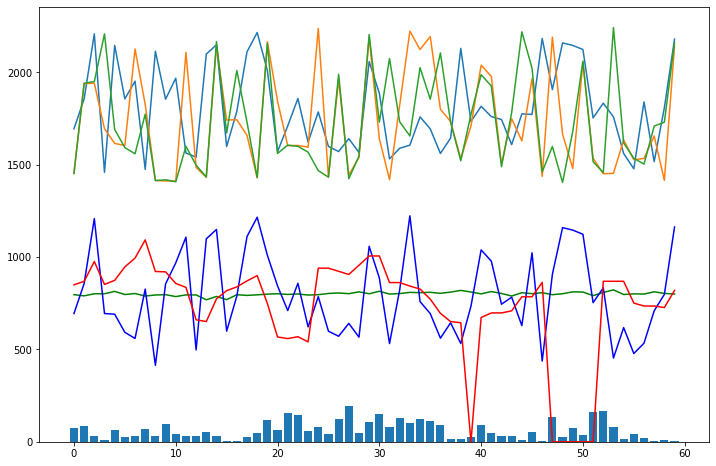

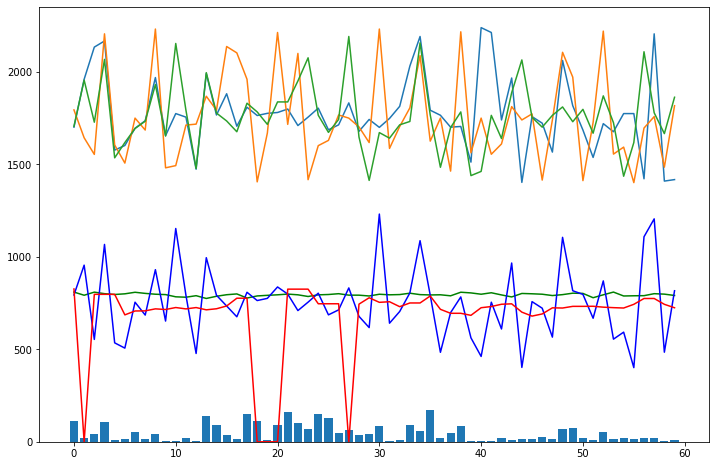

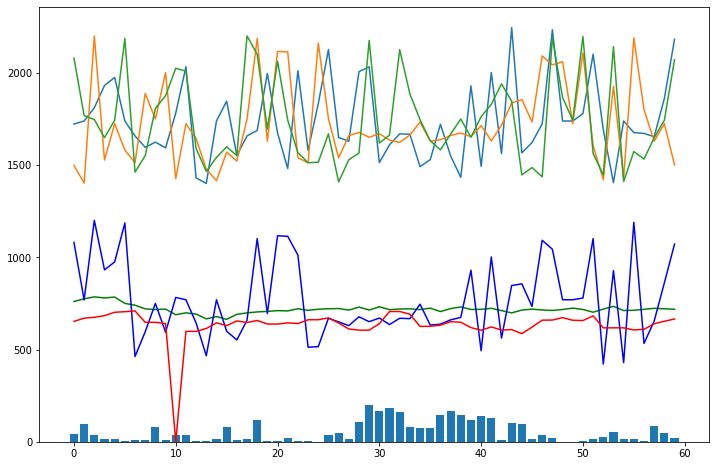

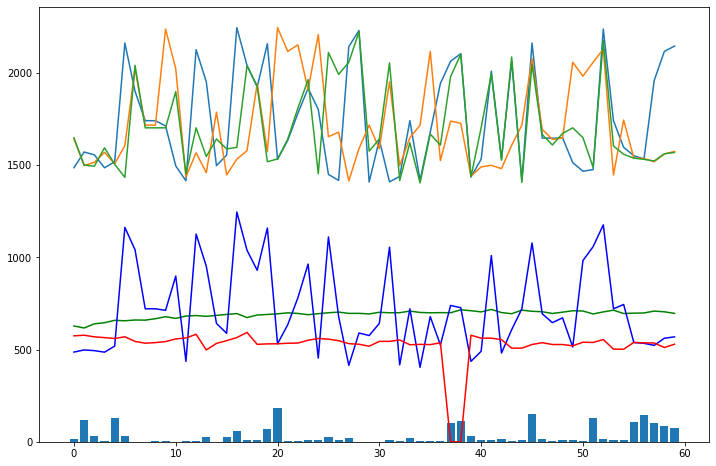

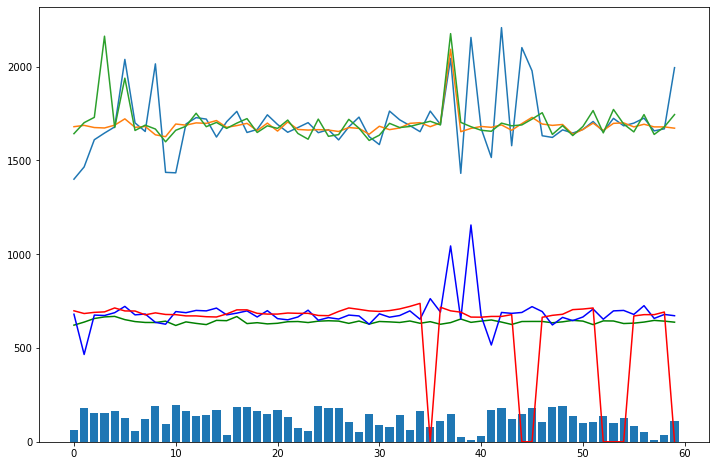

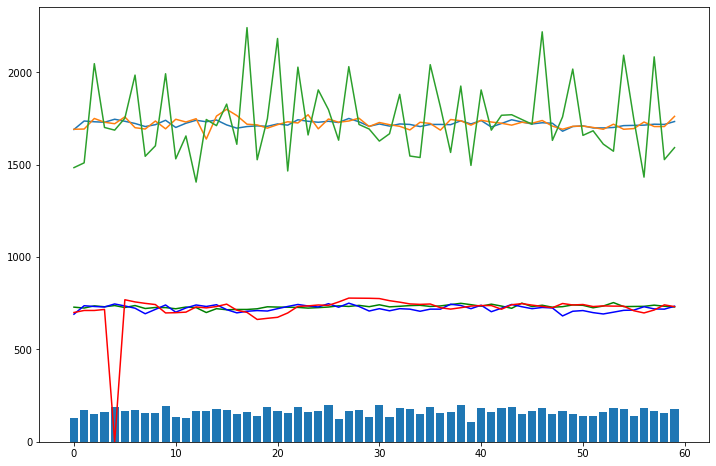

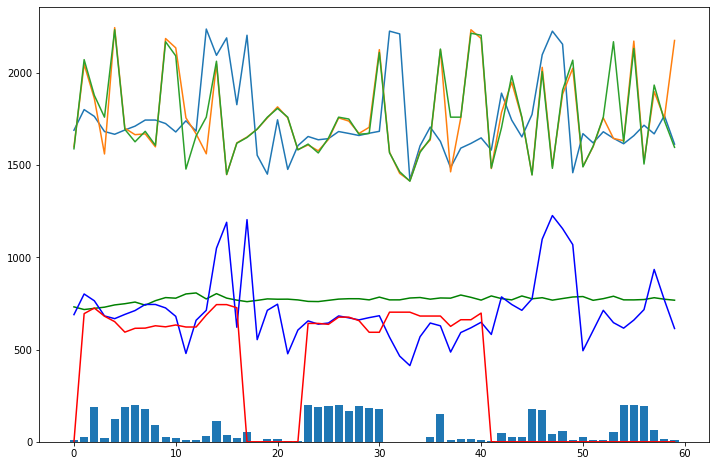

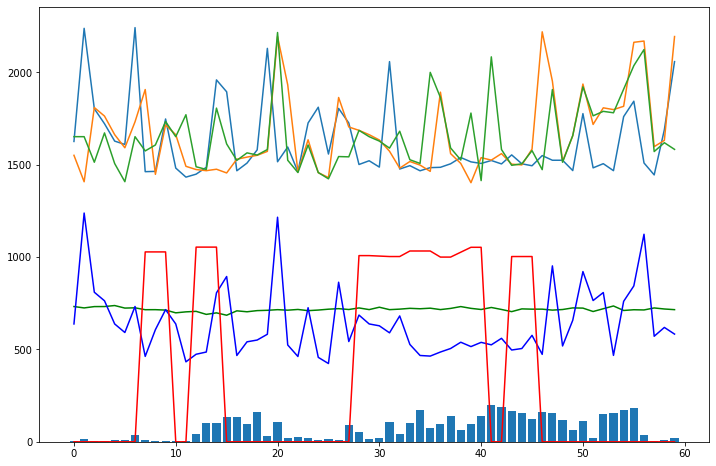

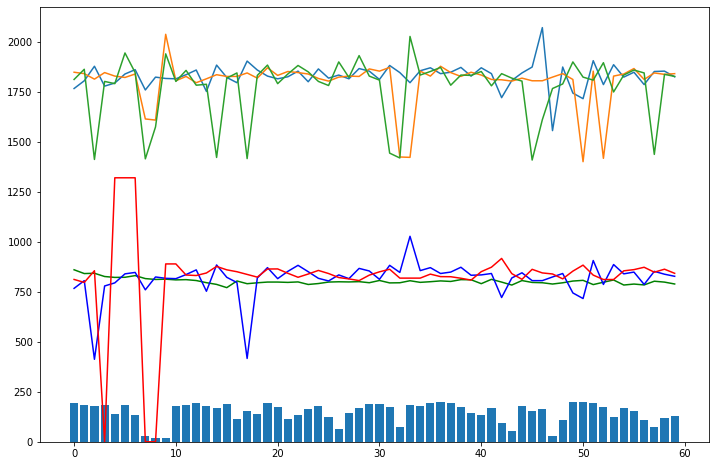

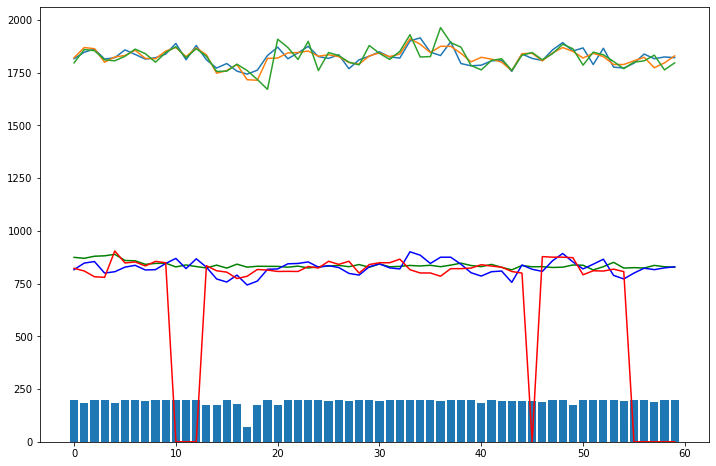

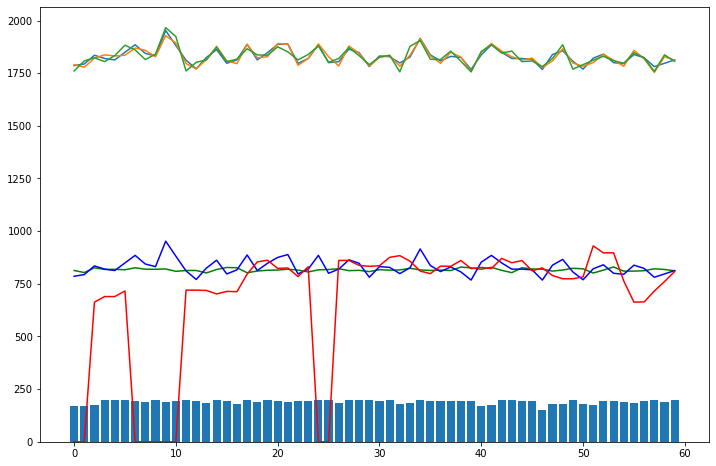

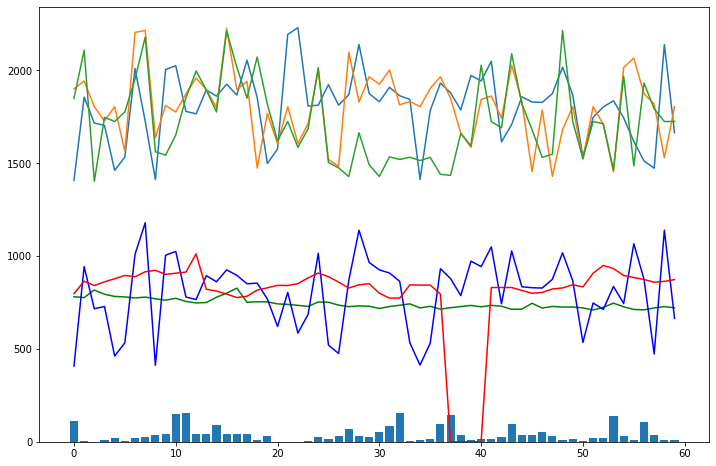

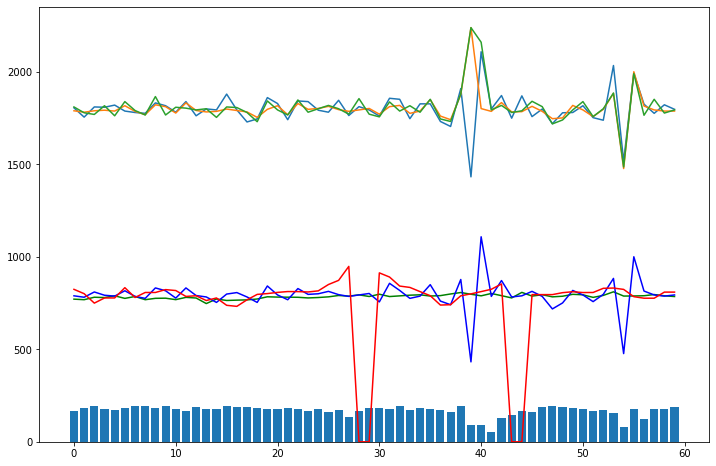

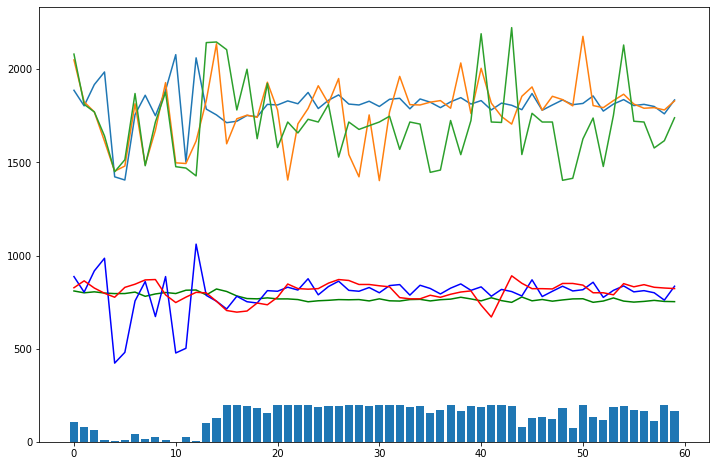

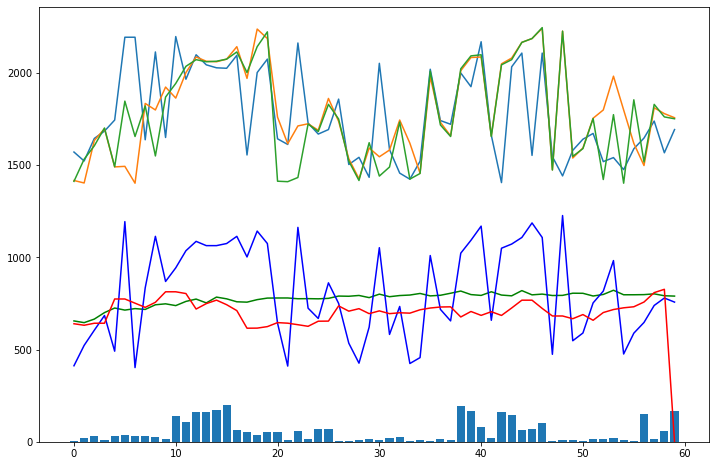

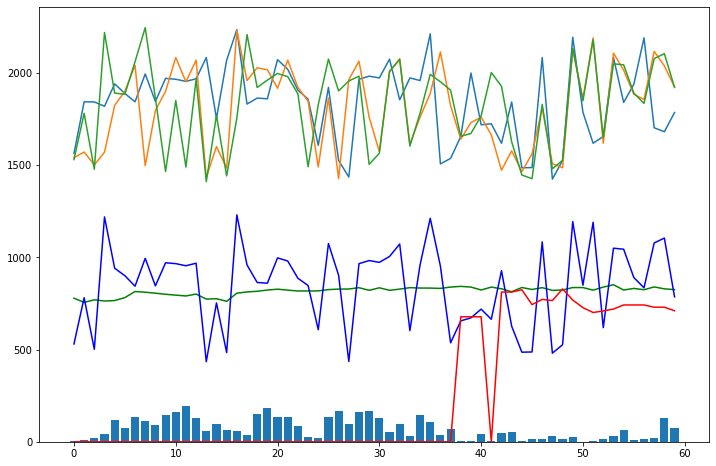

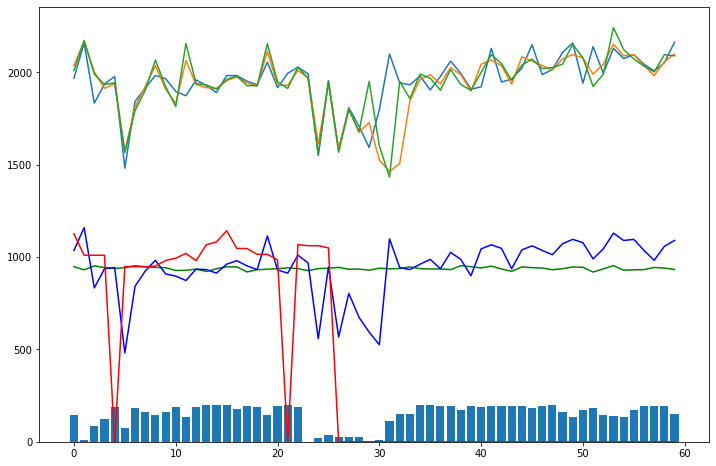

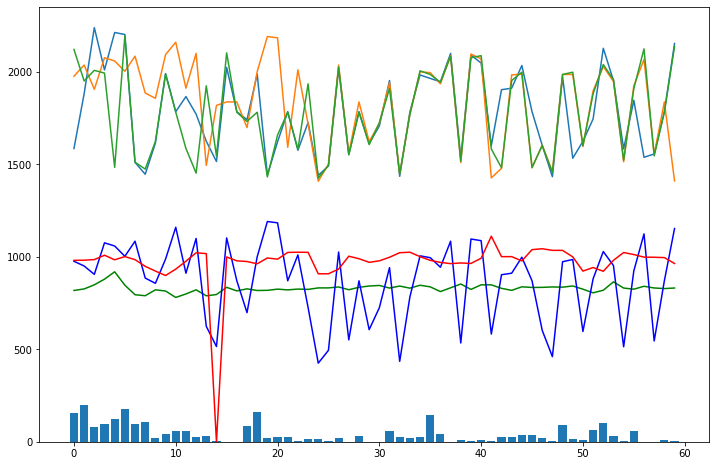

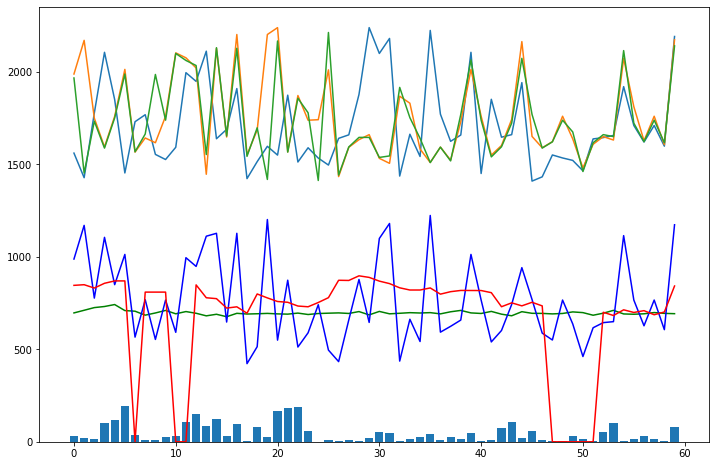

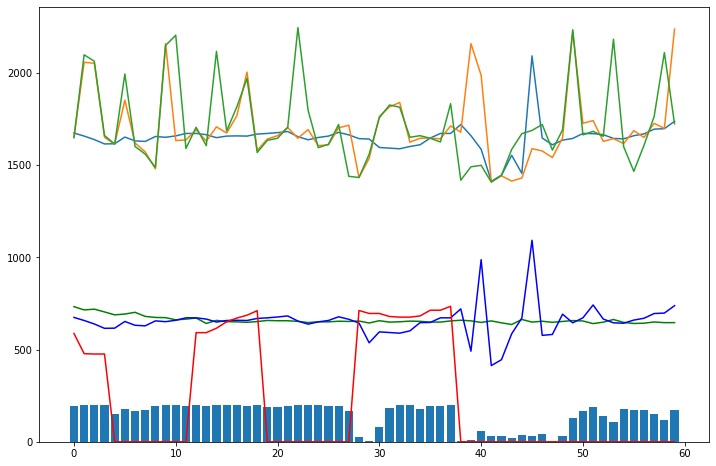

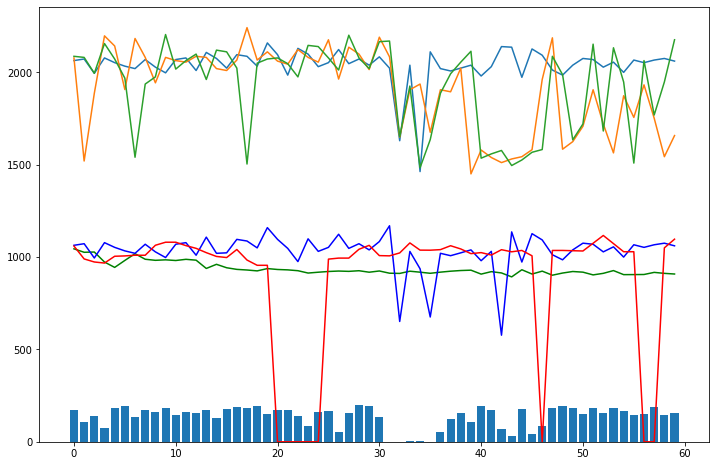

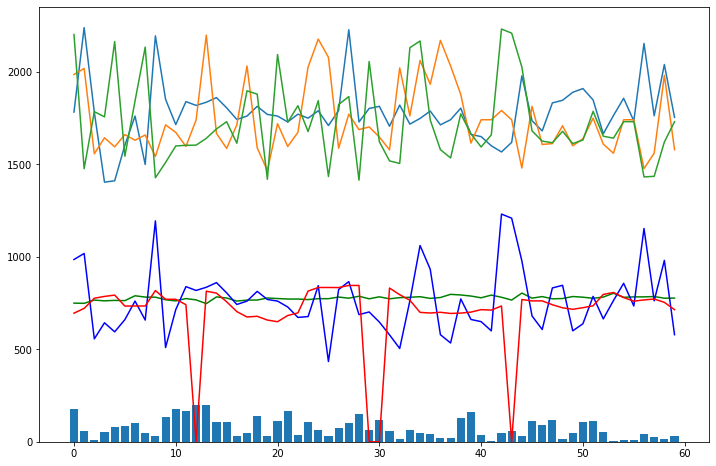

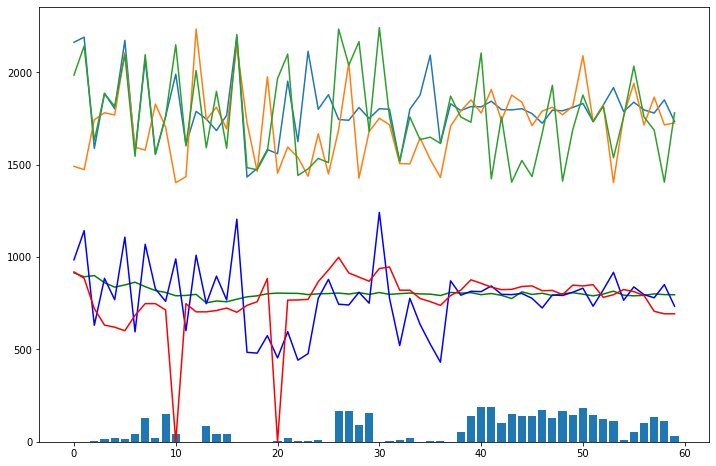

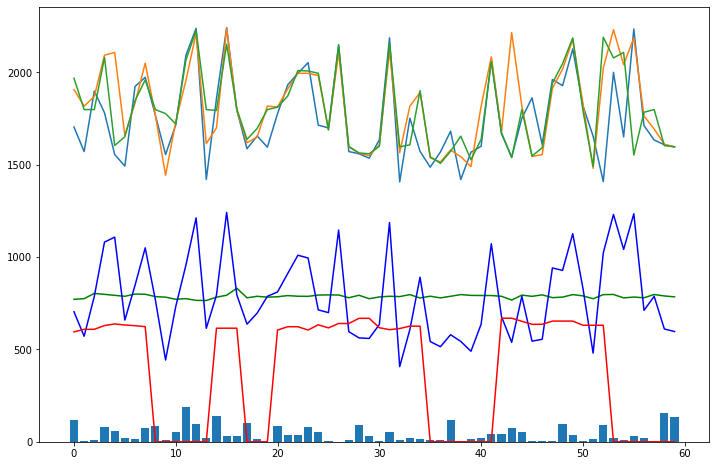

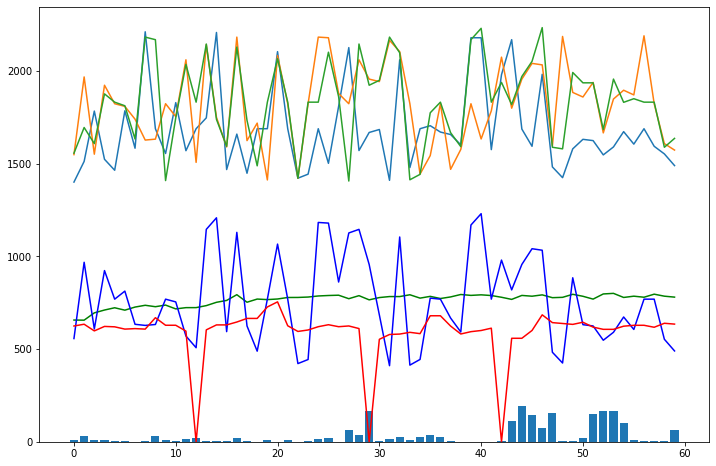

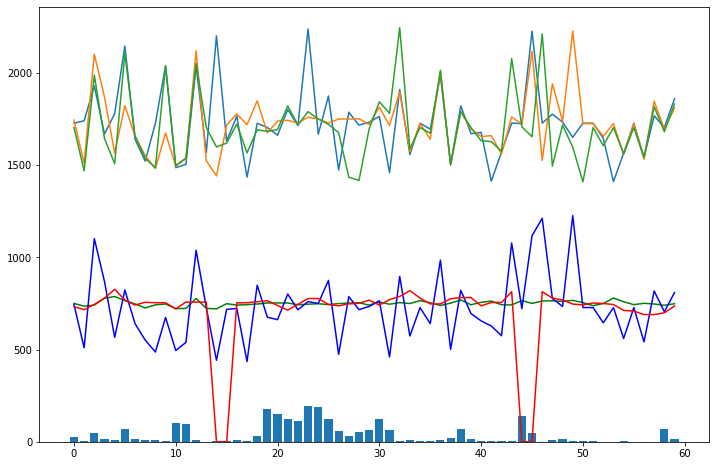

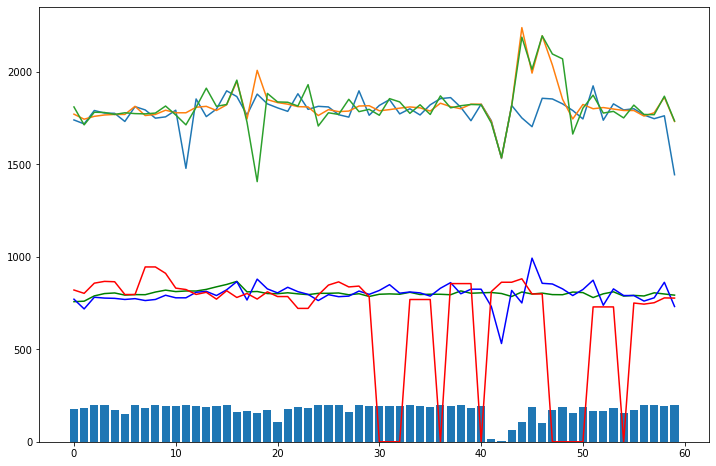

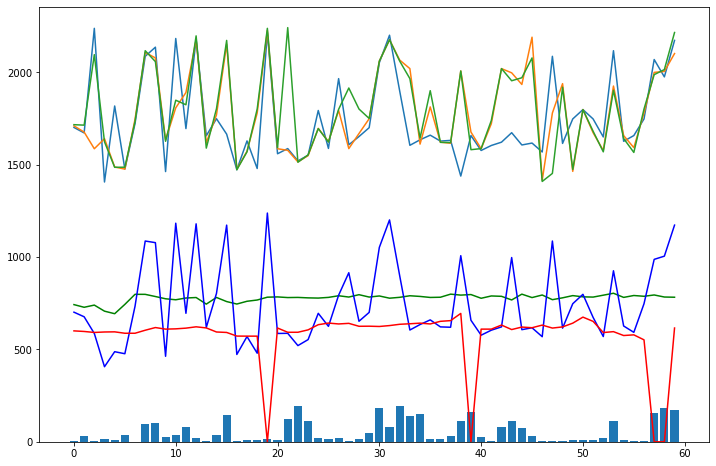

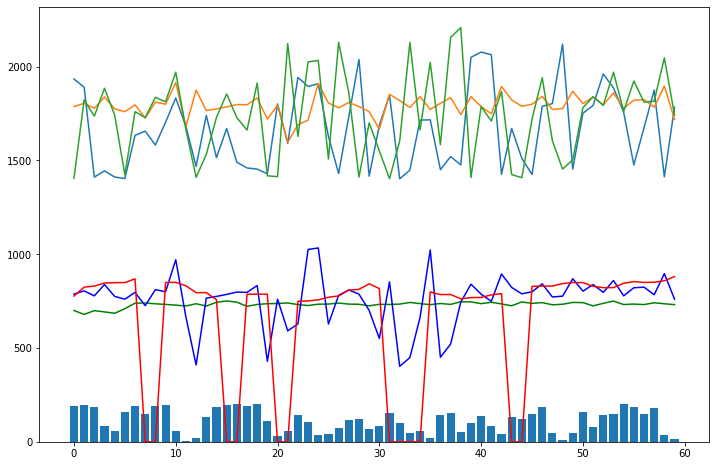

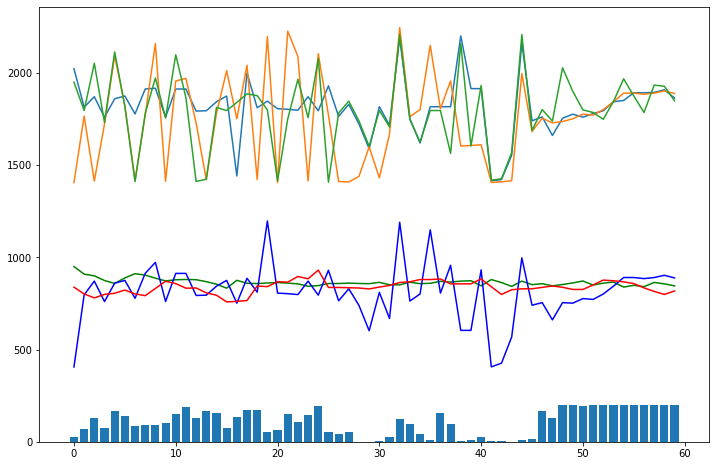

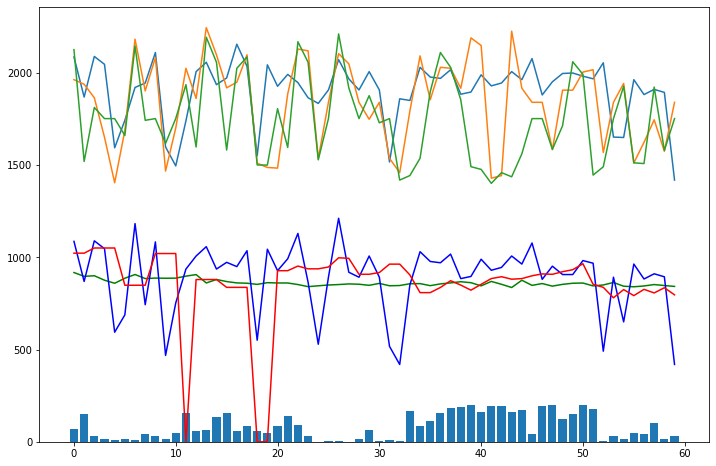

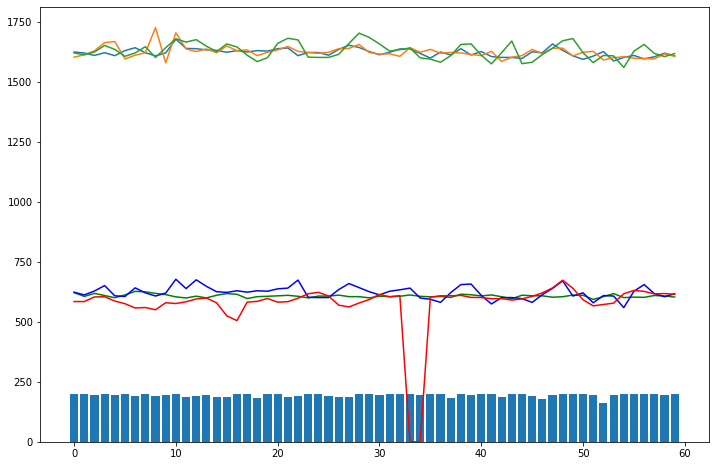

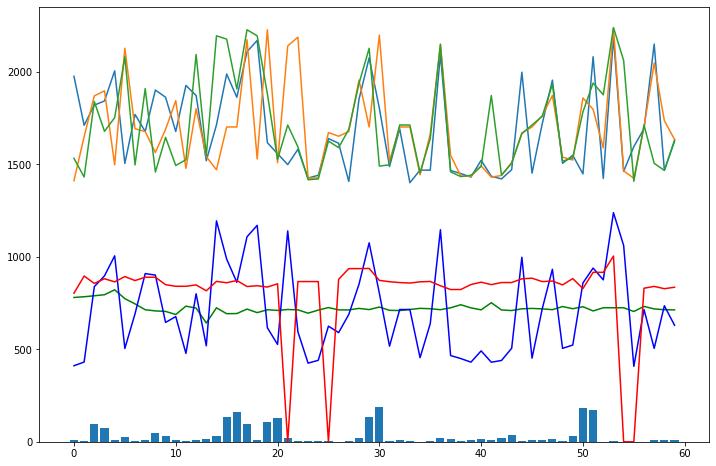

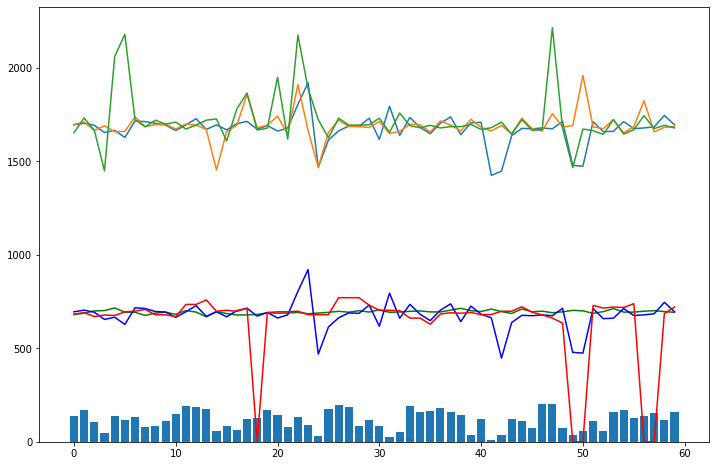

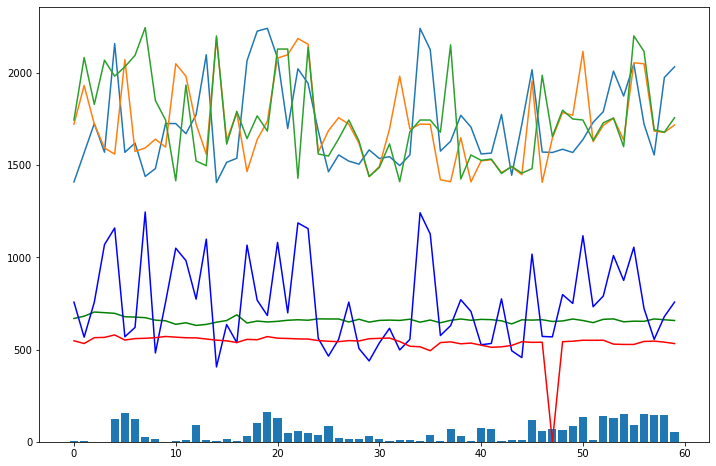

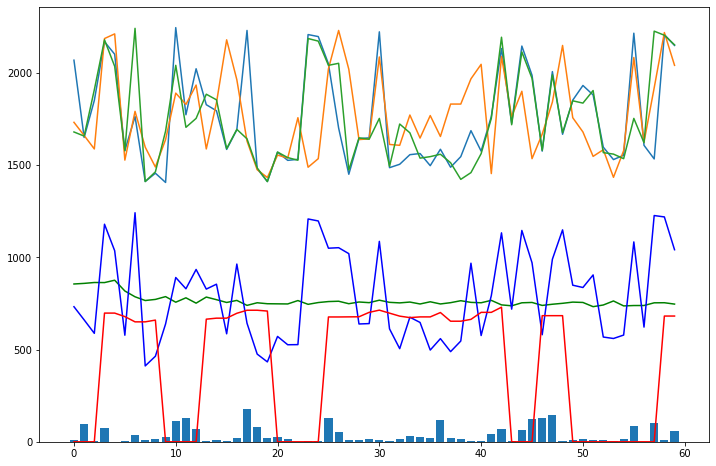

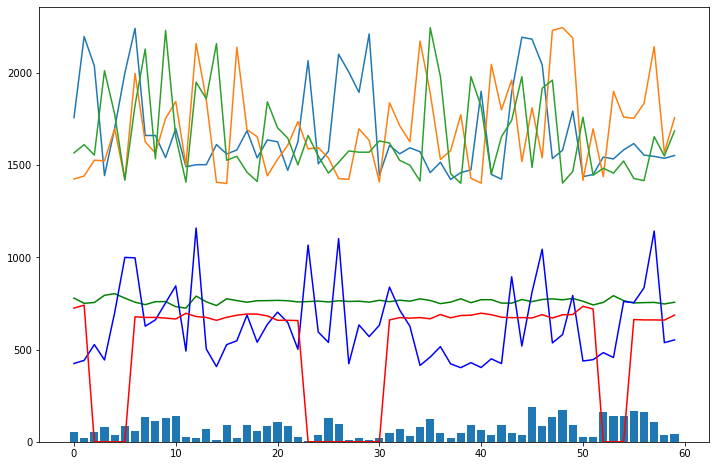

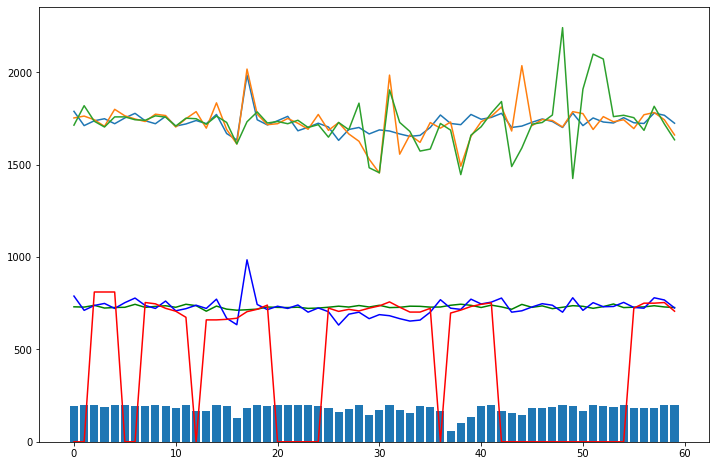

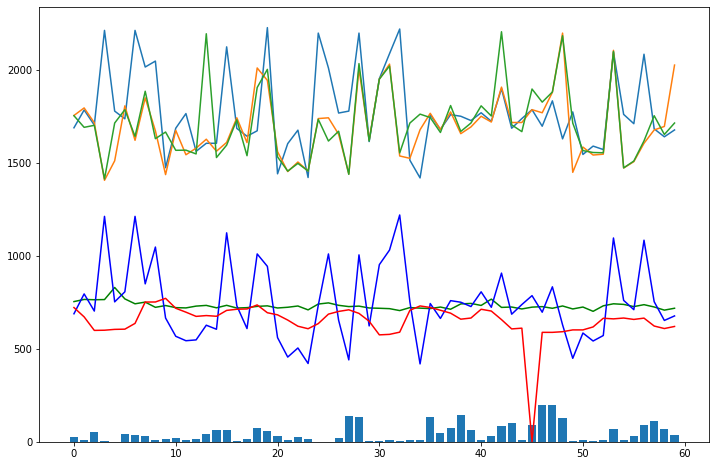

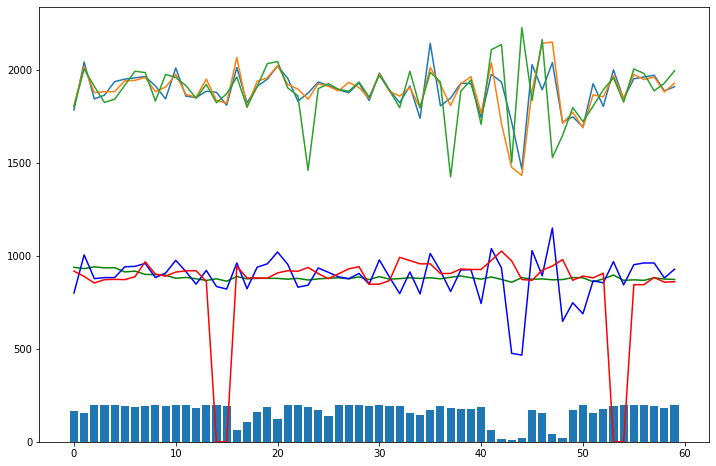

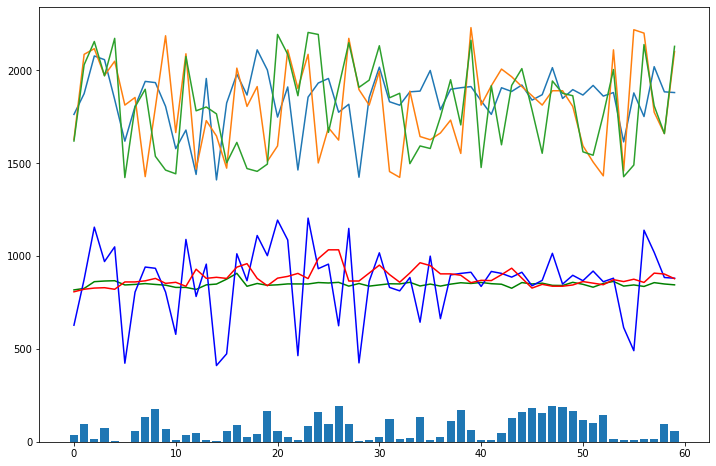

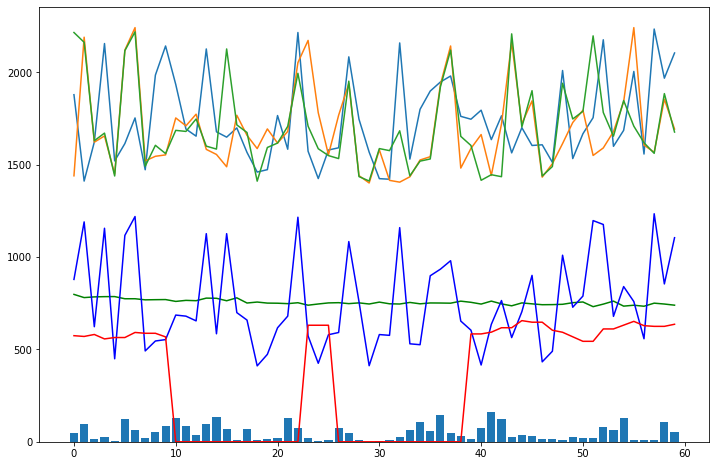

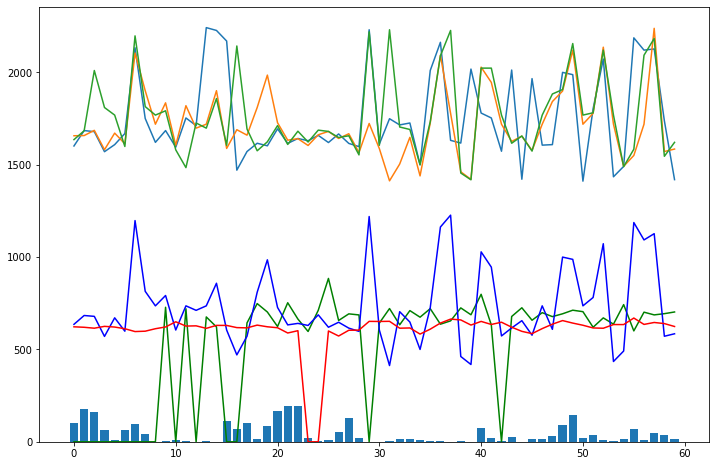

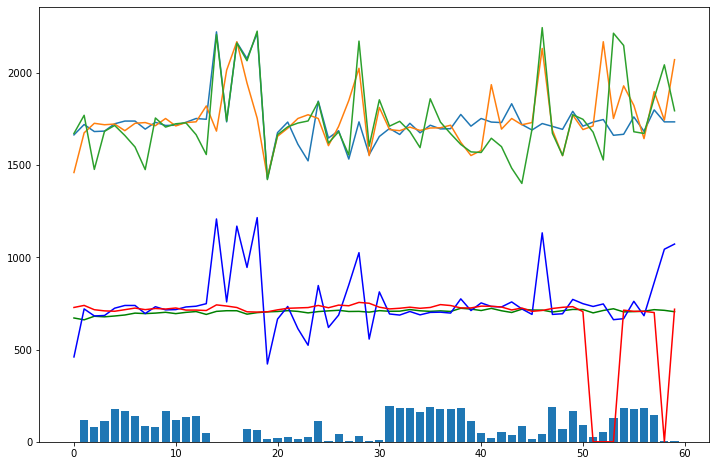

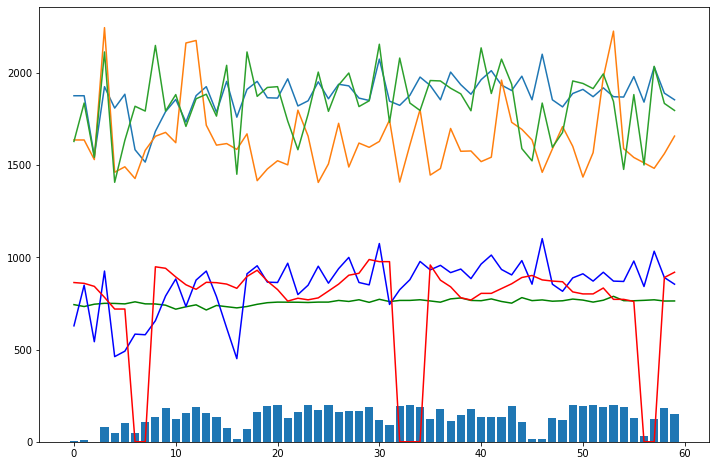

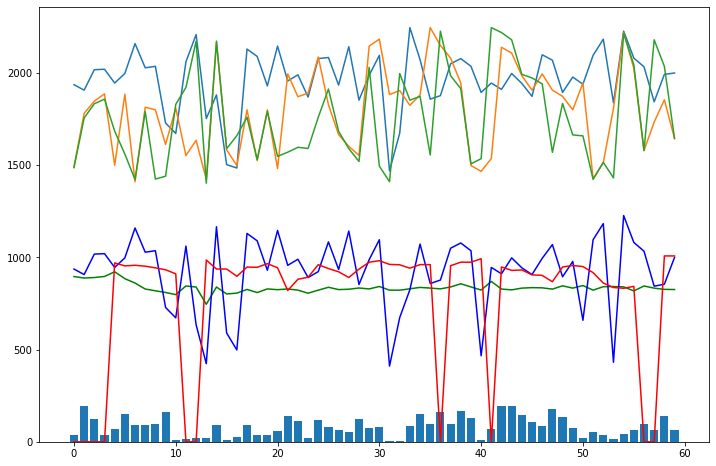

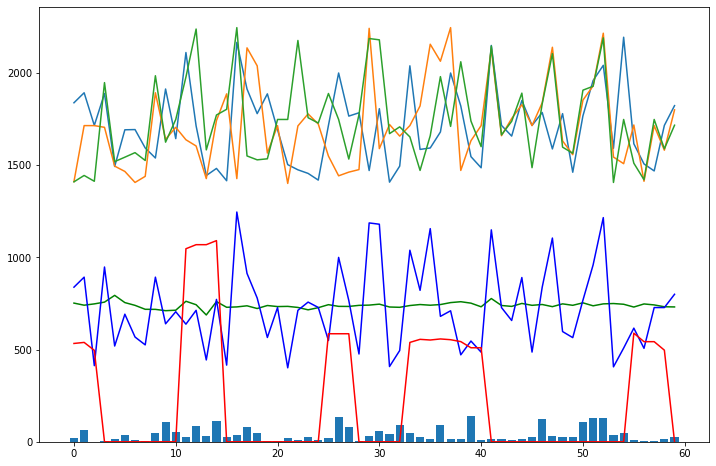

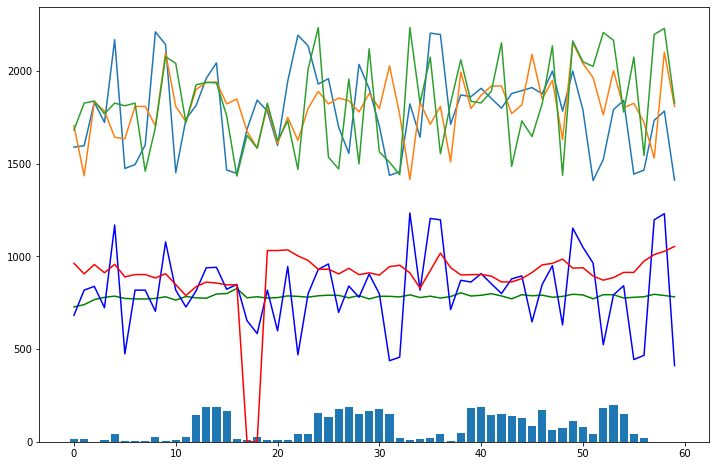

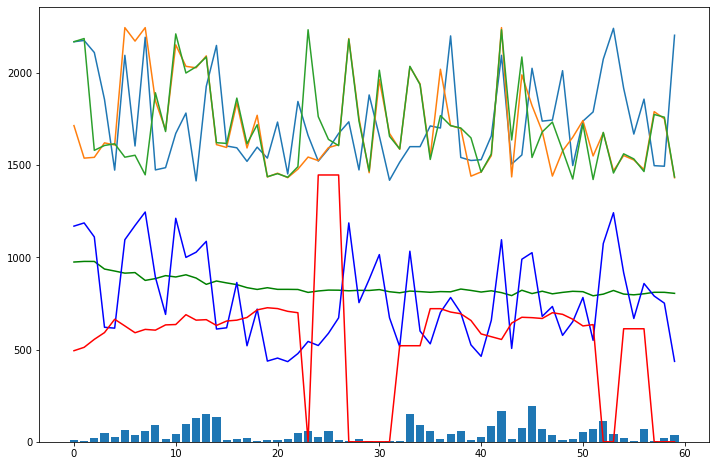

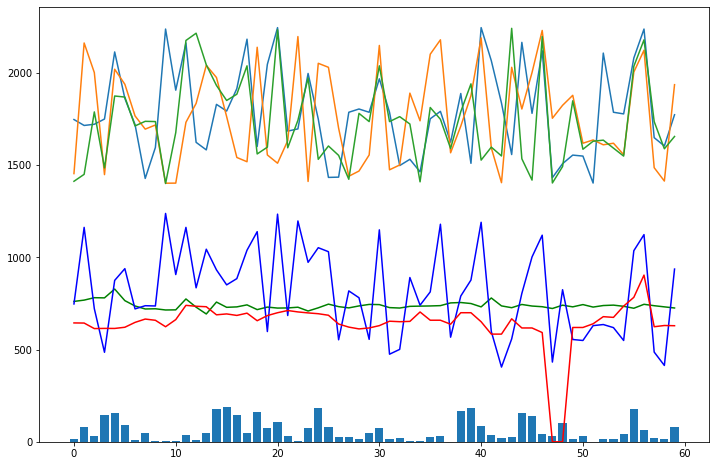

In [20]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:50]):
#     if np.sum(a)>0:
    plt.figure(figsize=(12,8))
    plt.plot(a,'g')
    plt.plot(X_test[i,:,:3]+1000)
    plt.plot(y_test[i],'b')
#     plt.bar(range(60),y_test[i]*400,.9)
#     plt.bar(range(60),quals_test[i]*400,.45)
    plt.plot(ecg_test[i],'r')
    plt.bar(range(60),quals_test[i]*200)
    plt.show()

In [ ]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [ ]:
X = X[X[:,0]>=0]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

In [ ]:
plt.figure()
plt.hist(X[:,0],20)
plt.show()
# y_test = y_test[:,:,0]
# X[:,0] = X[:,0]

In [ ]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
# b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
# for box in b['boxes']:
#     box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
from hrvanalysis import get_time_domain_features,get_frequency_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    index = np.where(qual_min>=0)[0]
#     print(len(np.where(qual_min==-1)[0]))
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    ecg_min= ecg_min[~np.isinf(ecg_min)]
    
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_pred_min = y_pred_min[~np.isinf(y_pred_min)]
    
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[index] 
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    y_test_min = y_test_min[~np.isinf(y_test_min)]
    if len(ecg_min)<5 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
#     x.append(np.array(list(get_frequency_domain_features(y_pred_min).values())))
#     y.append(np.array(list(get_frequency_domain_features(ecg_min).values())))
#     z.append(np.array(list(get_frequency_domain_features(y_test_min).values())))
    q.append(len(np.where(qual_min>.5)[0])/60)

In [ ]:
preds,ecgs,fpreds,q = np.array(x),np.array(y),np.array(z),np.array(q)

In [ ]:
preds.shape,ecgs.shape,fpreds.shape,q.shape

In [ ]:
preds[:,-4]

In [ ]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    for i in np.linspace(0,.95,20):
        index = np.where((q>=i)&(q<=i+.5))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(str(np.round(100*i)/100))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
        except:
            continue
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x,y1,.25,label='PPG Prediction')
        plt.title(feature_col[j])
#         plt.ylim([0,1])
        plt.legend()
#         plt.xticks(rotation=60)
        plt.show()
    except Exception as e:
        continue

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability